# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 7: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(112358)

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from PIL import Image, ImageOps

# TensorFlow and tf.keras
import tensorflow as tf

%matplotlib inline

tf.keras.backend.clear_session()

<hr style="height:2pt">

### INSTRUCTIONS

- **THIS IS AN INDIVIDUAL ASSIGNMENT.**

- **DO NOT PROCRASTINATE! Expect your completed code in this notebook to take 20-60 minutes to run depending on your computer hardware.**

- To submit your assignment follow the instructions given in Canvas.

- This assignment **must be done individually.**

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit. Exceptions should be made for code with an extremely long execution time, of course.
- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.
- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**. 
- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```python
print(f'The R^2 is {R:.4f}')
```
- Your plots should be clearly labeled, including clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95% confidence interval of coefficients of polynomial degree 5" is).

<hr style="height:2pt">

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109A Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The included variables are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1questions"></a>

## <div class='exercise'>PART 1: Questions</div> 

[Return to contents](#contents)

<a id="q11"></a>

**[1.1:](#s11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

- **[1.1.1:](#s11)**  Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 


- **[1.1.2:](#s112)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

<a id="q12"></a>

**[1.2:](#s12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

<a id="q13"></a>

**[1.3:](#s13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.


- **[1.3.1:](#s13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.


- **[1.3.2:](#s132)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.


- **[1.3.3:](#s133)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>

**[1.4:](#s14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.


   - **[1.4.1:](#s14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

 
   - **[1.4.2:](#s142)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).


   - **[1.4.3:](#s143)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.


   - **[1.4.4:](#s144)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set. 


  - **[1.4.5:](#s145)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

<a id="q15"></a>

**[1.5:](#s15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>

**[1.6:](#s16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 


<a id="part1solutions"></a>

## PART 1: Solutions

[Return to contents](#contents)


<a id="s11"></a>
<div class='exercise-r'>  

**[1.1:](#q11) Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.

**[1.1.1:](#q11)** Read in the dataset `flights.csv`. Create a variable `DELAY_OR_NOT` that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed only if it arrives 15 minutes late or more). This is going to be the response variable for the rest of this question. 

</div>

In [3]:
# your code here
# read in data
df = pd.read_csv('data/flights.csv')
# create binary variable DELAY_OR_NOT and add to the end of the dataframe
df.insert(loc=len(df.columns),column='DELAY_OR_NOT',value=(df['ARRIVAL_DELAY'] >= 15).astype(int))

df.head()

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
0,23,2586.0,342.0,9,7,15,240.0,3,SFO,JFK,1
1,10,1235.0,185.0,5,6,11,366.0,4,LAX,DFW,0
2,-7,184.0,76.0,4,17,18,172.0,7,BOS,LGA,0
3,68,862.0,148.0,7,19,21,260.0,7,IAH,DEN,1
4,24,236.0,71.0,3,20,21,266.0,2,LAS,LAX,1


<a id="s112"></a>
<div class='exercise-r'>  

**[1.1.2:](#q11)** Preprocess the data: deal with missing values if there are any, one-hot-encode the non-numeric categorical variables, and split and scale the data (use an 80/20 train-test split with `random_state=111`). Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets. **NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.
    
</div>

In [4]:
# your code here
# Find the observations with missing values
# Code adapted from:
# https://www.kite.com/python/answers/how-to-find-rows-with-nan-values-in-a-pandas-dataframe-in-python
df[df.isnull().any(axis=1)]

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1


We see that all the missing values are for flights from BOS to SFO, so let's examine the observations of flights from BOS to SFO without missing values.

In [5]:
# your code here
df[(df['ORIGIN_AIRPORT']=='BOS') & (df['DESTINATION_AIRPORT'] == 'SFO')].dropna()

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
155,-17,2704.0,390.0,8,7,10,172.0,6,BOS,SFO,0
1729,16,2704.0,390.0,9,20,23,172.0,1,BOS,SFO,1
2775,-9,2704.0,403.0,3,11,14,172.0,1,BOS,SFO,0
3132,101,2704.0,412.0,2,16,20,172.0,4,BOS,SFO,1
5929,-5,2704.0,404.0,3,6,9,172.0,1,BOS,SFO,0
7111,150,2704.0,403.0,3,19,23,172.0,5,BOS,SFO,1


We see that the missing values for DISTANCE should be filled in with 2704.0 and the missing values for FLIGHT_COUNT should be filled in as 172.0

In [6]:
# your code here
df['DISTANCE'] = df['DISTANCE'].fillna(2704.0)
df['FLIGHT_COUNT'] = df['FLIGHT_COUNT'].fillna(172.0)
df[df.isnull().any(axis=1)]

,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
6375,17,2704.0,NaN,7,18,21,172.0,3,BOS,SFO,1


Since the only remaining missing observation is the SCHEDULED_TIME for a flight from BOS to SFO, it's reasonable to impute this observation by using an OLS regression model on the other observations of flights from BOS to SFO.

In [7]:
# your code here
from sklearn.linear_model import LinearRegression

temp_df = df[(df['ORIGIN_AIRPORT']=='BOS') & (df['DESTINATION_AIRPORT'] == 'SFO')
            ].drop(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'], axis=1)

# fit the imputation model
ols_imputer = LinearRegression().fit(temp_df.dropna().drop(['DELAY_OR_NOT','SCHEDULED_TIME'],axis=1),
                                     temp_df.dropna()['SCHEDULED_TIME'])

# perform some imputations
x1hat_impute = ols_imputer.predict(
    temp_df[temp_df.isnull().any(axis=1)].drop(['DELAY_OR_NOT','SCHEDULED_TIME'],axis=1))
df['SCHEDULED_TIME'] = df['SCHEDULED_TIME'].fillna(x1hat_impute[0])
# Check that there are no more missing values
df.isnull().sum()

ARRIVAL_DELAY          0
DISTANCE               0
SCHEDULED_TIME         0
MONTH                  0
SCHED_DEP_HOUR         0
SCHED_ARR_HOUR         0
FLIGHT_COUNT           0
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DELAY_OR_NOT           0
dtype: int64

In [8]:
# your code here
for predictor in ['ORIGIN_AIRPORT','DESTINATION_AIRPORT']:
    # one-hot encode all the categorical variables in two columns of our dataframe
    dummies = pd.get_dummies(df[predictor],prefix='one_hot_'+predictor)
    # add each column of one-hot encoded variable, but dropping the first
    for i in range(1,len(dummies.columns)):
        df.insert(loc=len(df.columns),column=dummies.columns[i],value=dummies[dummies.columns[i]])

In [9]:
# your code here
# assign predictors to drop for X
drop = ['ARRIVAL_DELAY','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DELAY_OR_NOT']

# assign the predictor variables
X = df.drop(drop,axis=1)

# assign the response variable
y = df['DELAY_OR_NOT']

# divide data using 80/20 train-test split with random_state=111
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=111)

Our numerical variables in our predictors are DISTANCE, SCHEDULED_TIME, FLIGHT_COUNT, MONTH, SCHED_DEP_HOUR, SCHED_ARR_HOUR, and DAY_OF_WEEK. So we shall standardize these variables.

In [10]:
# your code here
# standardize the train and test data
X_train_std = X_train.copy()
X_test_std = X_test.copy()
to_standardize = ['DISTANCE','SCHEDULED_TIME','FLIGHT_COUNT',
                  'SCHED_DEP_HOUR', 'SCHED_ARR_HOUR', 'MONTH', 'DAY_OF_WEEK']

scaler = StandardScaler().fit(X_train_std[to_standardize])

X_train_std[to_standardize] = scaler.transform(X_train_std[to_standardize])
X_test_std[to_standardize] = scaler.transform(X_test_std[to_standardize])

In [11]:
# your code here
# print the shape of the X and y for the train and test data
print('X train dataframe shape: ' + str(X_train_std.shape))
print('y train dataframe shape: ' + str(y_train.shape))
print('X test dataframe shape: ' + str(X_test_std.shape))
print('y test dataframe shape: ' + str(y_test.shape))

X train dataframe shape: (8000, 808)
y train dataframe shape: (8000,)
X test dataframe shape: (2000, 808)
y test dataframe shape: (2000,)


<a id="s12"></a>
<div class='exercise-r'>  
    
**[1.2:](#q12) Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs (you can base this number on the results of your training and validation accuracy plot), and feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model` training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.
    
</div>

In [12]:
# build your NN 
# your code here

# To build the NN, we will use the keras library
NN_model = tf.keras.models.Sequential(name='NN_model')

# We add the input layer
NN_model.add(tf.keras.layers.Input(shape = (X_train_std.shape[1],)))

# We add the first hidden layer with 15 neurons 
# and 'relu' activation
NN_model.add(tf.keras.layers.Dense(15, activation = 'relu', name='hidden1'))

# We add the second hidden layer with 15 neurons 
# and 'relu' activation
NN_model.add(tf.keras.layers.Dense(15, activation = 'relu', name='hidden2'))

# output layer, one neuron, using 'sigmoid' on the output labels
NN_model.add(tf.keras.layers.Dense(1, activation = 'sigmoid', name='output'))

In [13]:
# compile it and run it
# your code here 
# Now we compile the model using 'binary_crossentropy' loss, 
# optimizer as 'adam', and 'accuracy' as a metric
NN_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

NN_model.summary()

# We fit the model and set validation_split=0.2 for 20% of training data to be used for validation
history = NN_model.fit(X_train_std,y_train, epochs = 15, verbose = 0,validation_split = 0.2)

Model: "NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 15)                12135     
_________________________________________________________________
hidden2 (Dense)              (None, 15)                240       
_________________________________________________________________
output (Dense)               (None, 1)                 16        
Total params: 12,391
Trainable params: 12,391
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'NN_Model Accuracy')

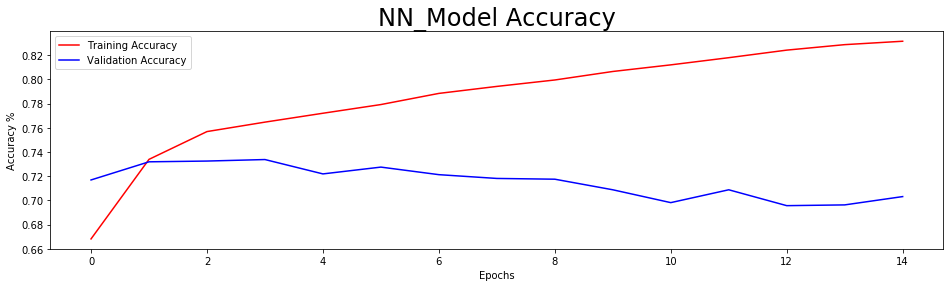

In [14]:
# plot train and val acc as a function of epochs
# your code here
# Here we plot the training and validation loss and accuracy

plt.figure(figsize=(16,4))
plt.plot(history.history['accuracy'],'r',label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs');
plt.ylabel('Accuracy %');
plt.title('NN_Model Accuracy', fontsize = 24)

In [15]:
# evaluate on train and test and print accuracy results
# your code here 
NN_model_train_accuracy = NN_model.evaluate(X_train_std,y_train,verbose=0)[1]
NN_model_test_accuracy = NN_model.evaluate(X_test_std,y_test,verbose=0)[1]
print(f'The training set accuracy for the NN_model is {round(NN_model_train_accuracy,4)}')
print(f'The test set accuracy for the NN_model is {round(NN_model_test_accuracy,4)}')

The training set accuracy for the NN_model is 0.82
The test set accuracy for the NN_model is 0.686


<a id="s13"></a>
<div class='exercise-r'>

**[1.3:](#q13) Fit and examine a "proxy" model**

To begin our interpretation of the resulting `NN_model`, we will first use a "proxy model" that we know how to interpret and train it on our `NN_model` class predictions rather than the true $y$ training values.
    
**[1.3.1:](#q13)** First, generate a set of `NN_model` class predictions for the training set. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.

</div>

In [16]:
# your code here
# get output layer predictions
y_pred = (NN_model.predict(X_train_std)>0.5).astype(int)

<a id="s132"></a>
<div class='exercise-r'>
    
**[1.3.2:](#q13)** Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Print the `logreg` test accuracy to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.

</div>

In [17]:
# your code here
from sklearn.linear_model import LogisticRegressionCV

# create and fit a LogisticRegression with ridge-like regularization using cross-validation
# to select the best hyperparameter C
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
logreg = LogisticRegressionCV(Cs=Cs, penalty='l2', max_iter = 5000).fit(X_train_std,y_pred[:,0])
print('Best Hyperparameter is C = ' + str(logreg.C_[0]))

# calculate LogisticRegression accuracy score on test set
logreg_test_score = logreg.score(X_test_std,y_test)
print('The test accuracy for the Logistic Regression model is: ' + str(round(logreg_test_score,4)))

Best Hyperparameter is C = 10.0
The test accuracy for the Logistic Regression model is: 0.7105


The test accuracy for the Logistic Regression is similar to the test accuracy for the ANN model in 1.2.

<a id="s133"></a>
<div class='exercise-r'>

**[1.3.3:](#q13)** Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

</div>

In [18]:
# your code here
# calculate feature importances using sklearn's permuation importance function
# per Mike Sedelmeyer's comment on Ed, we use the predicted y values to find the feature importance
# https://us.edstem.org/courses/2332/discussion/175118
logreg_result = permutation_importance(logreg,X_train_std,y_pred[:,0],n_jobs=-1)

# sort the importances in descending order by absolute values
ordered = np.sort(logreg_result.importances_mean)[::-1]
# empty lists to hold our importances and their associated feature names
features = []
importances = []
# counter
i = 0
while len(importances) < 10:
    index = np.where(abs(logreg_result.importances_mean) == ordered[i])[0]
    feature = list(X_train_std.columns[index])
    for x in range(len(feature)):
        importances.append(ordered[i])
        features.append(feature[x])
    i += len(feature)

Text(0.5, 1.0, 'Top 10 most important predictors in the Logistic Regression Model')

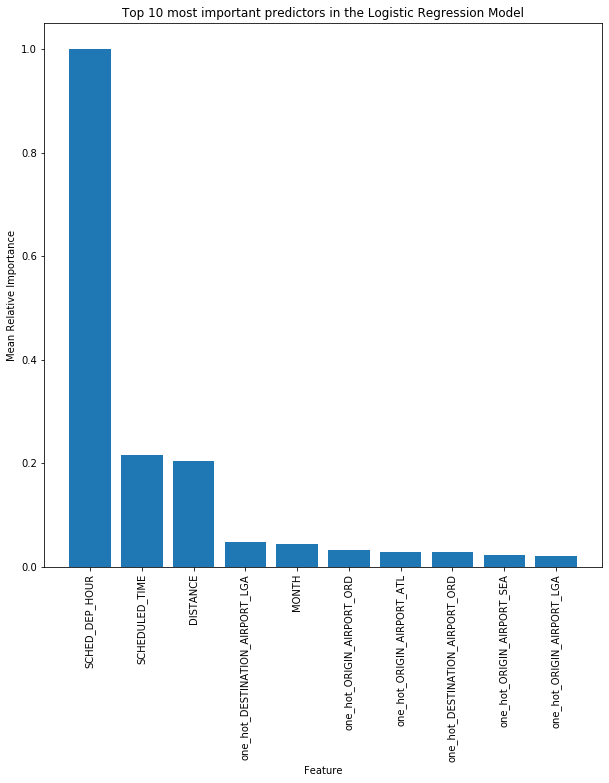

In [19]:
# your code here
relative_importances = np.array(importances)/np.max(importances)
plt.figure(figsize=(10,10))
plt.bar(x = range(1,11), height = relative_importances)
plt.xticks(range(1,11), features, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Mean Relative Importance')
plt.title('Top 10 most important predictors in the Logistic Regression Model')

<a id="s14"></a>
<div class='exercise-r'>

**[1.4:](#q14) Visualize important features**

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. **For all 1.4 plots below**, for ease of interpretation, **please be certain to** display all predictors on their original scales. **NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.

**[1.4.1:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences. 

</div>

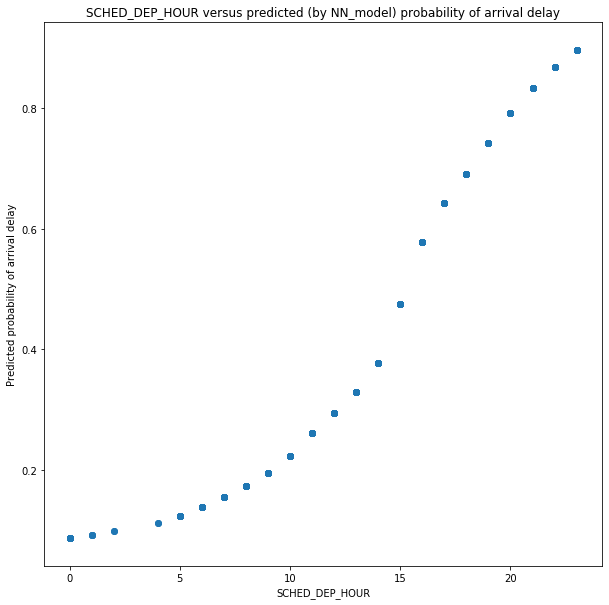

In [20]:
# your code here
# Making our input features (SCHED_DEP_HOUR varying)
X_141 = X_train_std.copy()

# Set numerical variables (besides SCHED_DEP_HOUR) to their means
numerical_vars = ['DISTANCE','SCHEDULED_TIME','FLIGHT_COUNT',
                  'SCHED_ARR_HOUR','MONTH','DAY_OF_WEEK']

for c in X_141.columns:
    if c == 'SCHED_DEP_HOUR':
        pass
    elif np.isin(c, numerical_vars):
        X_141[c]=X_141[c].mean()
    else:
        X_141[c]=X_141[c].mode()[0]


# Make NN_model predictions of probability delay
predictions_141 = NN_model.predict(X_141)

# Plot NN_model predictions
plt.figure(figsize=(10,10))
plt.scatter(X_train['SCHED_DEP_HOUR'],predictions_141)
plt.xlabel('SCHED_DEP_HOUR')
plt.ylabel('Predicted probability of arrival delay')
plt.title('SCHED_DEP_HOUR versus predicted (by NN_model) probability of arrival delay')
plt.show()

**INTERPRETATION:**

*Your answer here*

From the plot we see that the predicted probability of arrival delay by the NN_model increases monotonically as SCHED_DEP_HOUR increases. This can be interpreted as showing that flights that are scheduled for a later time in the day are more likely to have an arrival delay. Between SCHED_DEP_HOUR of 0 to 15, the predicted probability of arrival delay increases at an increasing rate, and betweeen 15 to 24, the predicted probability of arrival delay increases at a decreasing rate. Observe that the ranges of predicted probabilities in the graph ranges from approaximately 0.1 to approximately 0.9, which helps to confirm our results from 1.3.3 that SCHED_DEP_HOUR is by far the feature that has the greatest effect on the probability of a flight having an arrival delay since the plot shows that it can effectively delineate on its own which flights are almost certain to have an arrival delay and which flights are almost certain not to have an arrival delay.

<a id="s142"></a>
<div class='exercise-r'>

**[1.4.2:](#q14)** Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `FLIGHT_COUNT` from the training set (see the question 1.4 "HINT" below).

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. Please refer to the matplotlib documentation for examples.

</div>

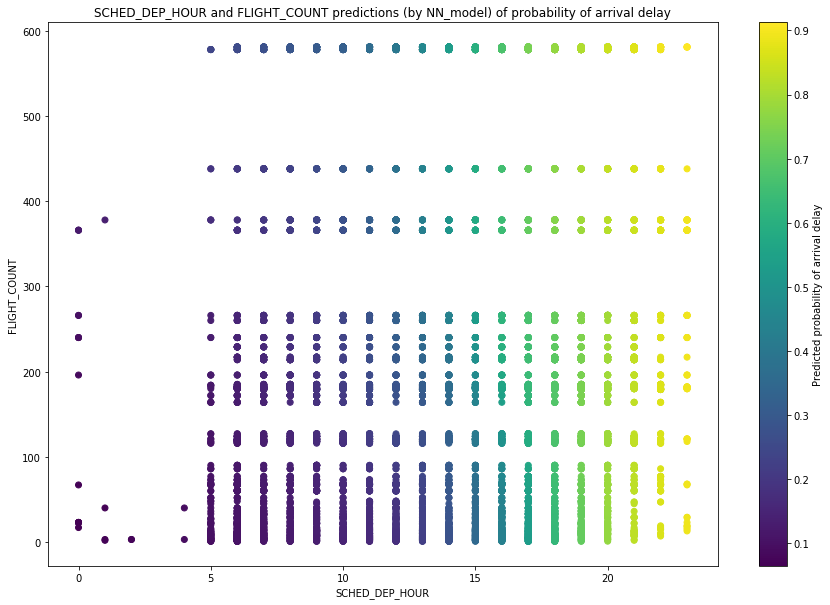

In [21]:
# your code here
# Making our input features (SCHED_DEP_HOUR varying)
X_142 = X_train_std.copy()

# Set numerical variables (besides SCHED_DEP_HOUR and FLIGHT_COUNT) to their means
numerical_vars = ['DISTANCE','SCHEDULED_TIME',
                  'SCHED_ARR_HOUR','MONTH','DAY_OF_WEEK']

for c in X_142.columns:
    if (c == 'SCHED_DEP_HOUR') | (c == 'FLIGHT_COUNT'):
        pass
    elif np.isin(c, numerical_vars):
        X_142[c]=X_142[c].mean()
    else:
        X_142[c]=X_142[c].mode()[0]


# Make NN_model predictions of probability delay
predictions_142 = NN_model.predict(X_142)

# Plot NN_model predictions
plt.figure(figsize=(15,10))
plt.scatter(x = X_train['SCHED_DEP_HOUR'],y = X_train['FLIGHT_COUNT'],
            c = predictions_142.ravel(), cmap = 'viridis')
plt.colorbar(label='Predicted probability of arrival delay')
plt.xlabel('SCHED_DEP_HOUR')
plt.ylabel('FLIGHT_COUNT')
plt.title('SCHED_DEP_HOUR and FLIGHT_COUNT predictions (by NN_model) of probability of arrival delay')
plt.show()

<a id="s143"></a>
<div class='exercise-r'>

**[1.4.3:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` from the training set.
    
</div>

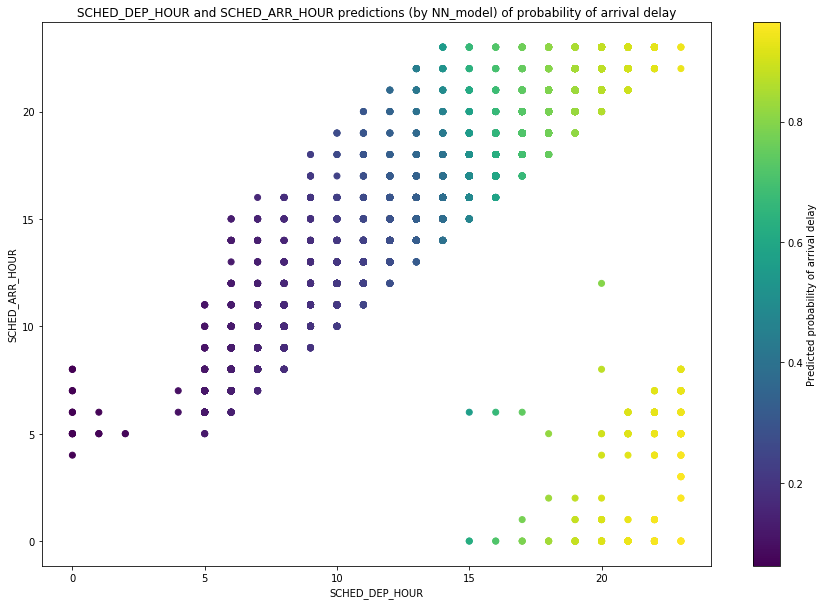

In [22]:
# your code here
# Making our input features (SCHED_DEP_HOUR varying)
X_143 = X_train_std.copy()

# Set numerical variables (besides SCHED_DEP_HOUR and SCHED_ARR_HOUR) to their means
numerical_vars = ['DISTANCE','SCHEDULED_TIME', 'FLIGHT_COUNT',
                  'MONTH','DAY_OF_WEEK']

for c in X_143.columns:
    if (c == 'SCHED_DEP_HOUR') | (c == 'SCHED_ARR_HOUR'):
        pass
    elif np.isin(c, numerical_vars):
        X_143[c]=X_143[c].mean()
    else:
        X_143[c]=X_143[c].mode()[0]


# Make NN_model predictions of probability delay
predictions_143 = NN_model.predict(X_143)

# Plot NN_model predictions
plt.figure(figsize=(15,10))
plt.scatter(x = X_train['SCHED_DEP_HOUR'],y = X_train['SCHED_ARR_HOUR'],
            c = predictions_143.ravel(), cmap = 'viridis')
plt.colorbar(label='Predicted probability of arrival delay')
plt.xlabel('SCHED_DEP_HOUR')
plt.ylabel('SCHED_ARR_HOUR')
plt.title('SCHED_DEP_HOUR and SCHED_ARR_HOUR predictions (by NN_model) of probability of arrival delay')
plt.show()

<a id="s144"></a>
<div class='exercise-r'>

**[1.4.4:](#q14)** Set all predictors to their means/modes except for except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` and `DISTANCE` from the training set.
    
</div>

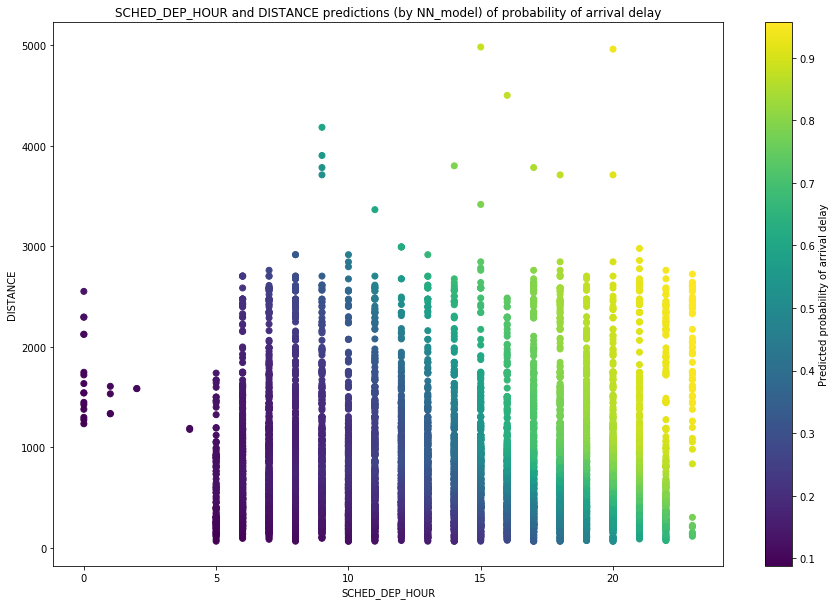

In [23]:
# your code here
# Making our input features (SCHED_DEP_HOUR varying)
X_144 = X_train_std.copy()

# Set numerical variables (besides SCHED_DEP_HOUR and DISTANCE) to their means
numerical_vars = ['SCHEDULED_TIME', 'FLIGHT_COUNT',
                  'SCHED_ARR_HOUR','MONTH','DAY_OF_WEEK']

for c in X_144.columns:
    if (c == 'SCHED_DEP_HOUR') | (c == 'DISTANCE'):
        pass
    elif np.isin(c, numerical_vars):
        X_144[c]=X_144[c].mean()
    else:
        X_144[c]=X_144[c].mode()[0]


# Make NN_model predictions of probability delay
predictions_144 = NN_model.predict(X_144)

# Plot NN_model predictions
plt.figure(figsize=(15,10))
plt.scatter(x = X_train['SCHED_DEP_HOUR'],y = X_train['DISTANCE'],
            c = predictions_144.ravel(), cmap = 'viridis')
plt.colorbar(label='Predicted probability of arrival delay')
plt.xlabel('SCHED_DEP_HOUR')
plt.ylabel('DISTANCE')
plt.title('SCHED_DEP_HOUR and DISTANCE predictions (by NN_model) of probability of arrival delay')
plt.show()

<a id="s145"></a>
<div class='exercise-r'>

**[1.4.5:](#q14)** In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.
    
</div>

**INTERPRETATION:**

*Your answer here*

In all three of the plots from 1.4.2, 1.4.3, and 1.4.4, we see that the changes in colors (corresponding to the changes in predicted probability of arrival delay) occur nearly exclusively along the x-axis. This also confirms our results from 1.3.3 and 1.4.1 which show that SCHED_DEP_HOUR is by far the best and most important predictor for the probability of arrival delay, since if the predicted probability only shows changes along the x-axis and not the y-axis in our 3 plots, that implies that SCHED_DEP_HOUR accounts for nearly all of the effect on the predicted probabilities and FLIGHT_COUNT, SCHED_ARR_HOUR, and DISTANCE account for nearly none of the effect on the predicted probabilities. The one slight exception, is that DISTANCE shows a greater effect on the predicted probabilities than FLIGHT_COUNT and SCHED_ARR_HOUR, since the plot in 1.4.4 is the only plot that shows some changes in predicted probabilities (colors) along the y-axis. Observe in the 1.4.4 plot that for the SCHED_DEP_HOUR of 15 to 24 there is some increase in the predicted probabilities for longer DISTANCE, but that there is not much change in predicted probabilities for longer DISTANCE when SCHED_DEP_HOUR is between 0 and 15. This also adds support to our results from 1.4.1 that shows SCHED_DEP_HOUR has a stronger effect on increasing predicted probabilities between 0 and 15 and a weaker effect on increasing predicted probabilities between 15 and 24. Moreover, this also adds support to our results from 1.3.3 that shows that DISTANCE is roughly tied with SCHEDULED_TIME as the second most important predictor which helps to explain why DISTANCE, and not FLIGHT_COUNT or SCHED_ARR_HOUR, showed a slight effect on the predicted probabilities.

<a id="s15"></a>
<div class='exercise-r'>

**[1.5:](#q15) Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (a minimum $n$ of at least 50 bootstraps should be used). Predict the output on the test data for each model. Randomly select 8 test observations and on 8 subplots, plot the distribution of predicted probabilities (i.e. $n$ bootstrapped probabilites) with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

</div>

In [24]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [25]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here
n_boots = 50
pred_prob = []
for i in range(n_boots):
    progressbar(i,n_boots)
    #tf.keras.backend.clear_session()
    
    boot_X, boot_y = resample(X_train_std, y_train)
    # To build the NN, we will use the keras library
    model = tf.keras.models.Sequential(name='bagging_model')
    
    # We add the input layer
    model.add(tf.keras.layers.Input(shape = (X_train_std.shape[1],)))

    # We add the first hidden layer with 15 neurons 
    # and 'relu' activation
    model.add(tf.keras.layers.Dense(15, activation = 'relu', name='hidden1'))

    # We add the second hidden layer with 15 neurons 
    # and 'relu' activation
    model.add(tf.keras.layers.Dense(15, activation = 'relu',name='hidden2'))

    # output layer, one neuron, using 'sigmoid' on the output labels
    model.add(tf.keras.layers.Dense(1, activation = 'sigmoid',name='output'))
    
    # Now we compile the model using 'binary_crossentropy' loss, 
    # and optimizer as 'sgd'
    model.compile(loss='binary_crossentropy',optimizer='adam')

    # We fit the model and set validation_split=0.2 for 20% of training data to be used for validation
    history = model.fit(boot_X,boot_y, epochs = 15, verbose = 0,validation_split = 0.2)
    
    pred_prob.append(model.predict(X_test_std))

 [==================================================] 50/50 Done...

CPU times: user 3min 14s, sys: 50.9 s, total: 4min 5s
Wall time: 2min 12s


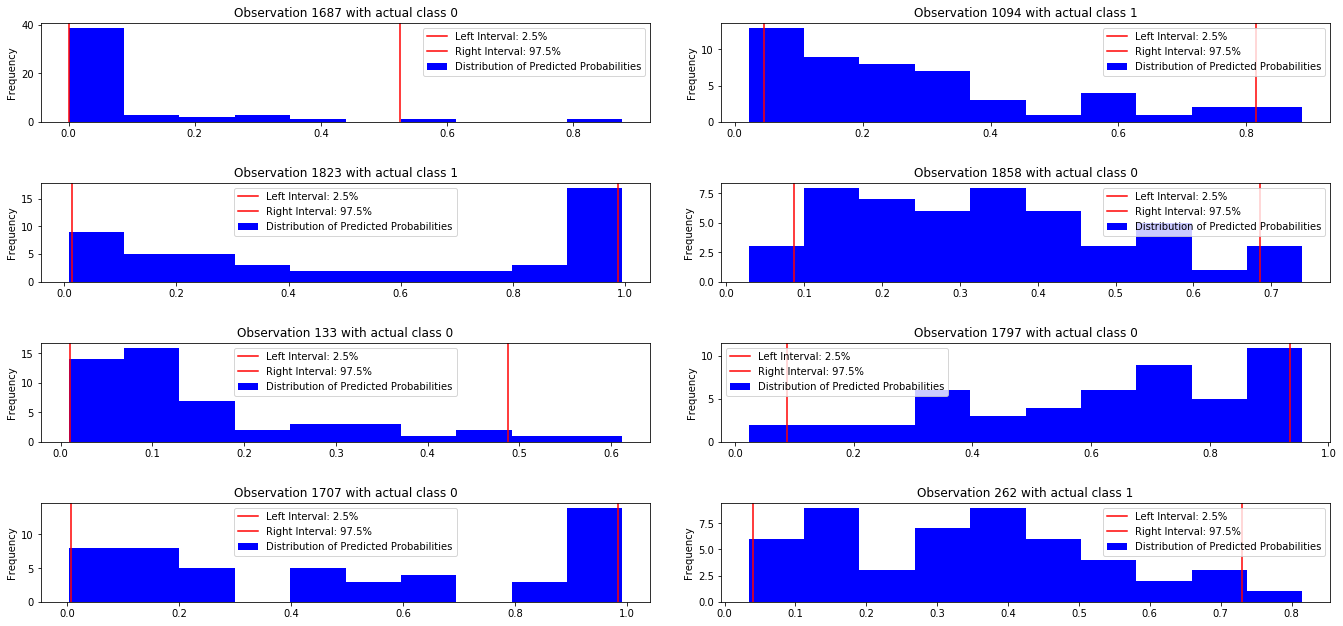

In [26]:
# generate your plot
# your code here
pred_prob = np.array(pred_prob)
select_8 = random.sample(range(2000), 8)
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(4*5, 2*5))
fig.tight_layout(pad=6,h_pad=4,w_pad=4)
axs_ravel = axs.ravel()

for i, j in enumerate(select_8):
    pred_prob[:,j].sort()
    axs_ravel[i].hist(pred_prob[:,j], color = 'b', label = 'Distribution of Predicted Probabilities')
    axs_ravel[i].axvline(np.percentile(pred_prob[:,j],2.5), color = 'r',label = 'Left Interval: 2.5%')
    axs_ravel[i].axvline(np.percentile(pred_prob[:,j],97.5), color = 'r',label = 'Right Interval: 97.5%')
    axs_ravel[i].set_title('Observation ' + str(j) + ' with actual class ' + str(y_test.iloc[j]))
    axs_ravel[i].set_ylabel('Predict Probability')
    axs_ravel[i].set_ylabel('Frequency')
    axs_ravel[i].legend()

plt.show()

**INTERPRETATION:**

*Your answer here*

There is considerable heterogeneity among our observations in their distributions of predicted probabilities. Observing from the histograms, the distributions for our 8 randomly selected observations are all very different, none of the distributions appear approximately normal, and most show high variability across the range of predicted probabilities, with some having a distribution of predicted probabilities that range across the entire set of feasible probabilities (that is ranging from approximately 0 probability to approximately 1 probability). This shows that our observations are all very different from one another and that means that the subset of observations selected in each bootstrapped sample has a big effect on how our NN model is fitted for that bootstrap, and ultimately what the predicted probabilities will be for that bootstrap.

<a id="s16"></a>
<div class='exercise-r'>

**[1.6:](#q16) Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how "significant" our bagged (i.e. bootstrap-aggregated) prediction will be for each test observation.

To accomplish this, you will first calculate the ratio of bootstrapped probabilities that cross the threshold value of $\hat{p}=0.5$. Let's call this ratio the **Posterior Prediction Ratio (PPR)**. When a bagged prediction's $PPR=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPR=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPR$ values for all test observations, you should have $n=2000$ $PPR$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for significance (i.e. maximum $PPR$ value) is not met. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPR$ threshold). You can make your abstain model *stricter* by using smaller $PPR$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPR$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPR$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPR$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model predicts confidently. 

</div>

Test accuracy of bagging model predictions from question 1.5: 0.707


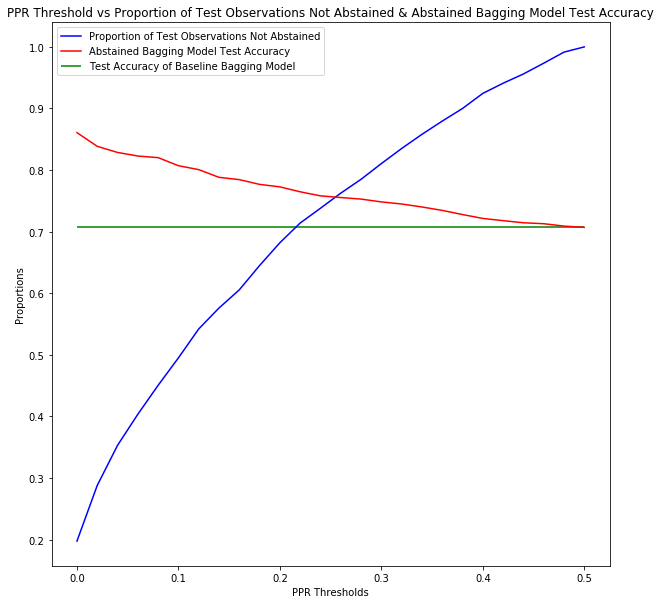

In [27]:
# your code here
PPR = []
bagging_pred = []
for i in range(len(pred_prob[0])):
    nums = [0,0]
    for j in pred_prob[:,i]:
        if j > 0.5:
            nums[1] += 1
        else:
            nums[0] += 1
    bagging_pred.append(np.argmax(nums))
    PPR.append(float(np.min(nums))/float(np.sum(nums)))

bagging_test_score = accuracy_score(y_test, bagging_pred)
print('Test accuracy of bagging model predictions from question 1.5: ' + str(round(bagging_test_score,4)))

thresholds = np.arange(0,0.52,0.02)
abstain_test_scores = []
num_abstain = []
for t in thresholds:
    to_drop = []
    y_preds = []
    y_trues = []
    for i in range(len(PPR)):
        if PPR[i] > t:
            to_drop.append(i)
        else:
            y_trues.append(y_test.iloc[i])
            y_preds.append(bagging_pred[i])
    num_abstain.append(len(to_drop))
    abstain_test_scores.append(accuracy_score(y_trues,y_preds))

prop_not_abstain = 1-np.array(num_abstain)/2000

plt.figure(figsize=(10,10))
plt.plot(thresholds,prop_not_abstain, color = 'b', label = 'Proportion of Test Observations Not Abstained')
plt.plot(thresholds,abstain_test_scores, color = 'r', label = 'Abstained Bagging Model Test Accuracy')
plt.hlines(bagging_test_score, xmin=0, xmax=0.5,color = 'g', label = 'Test Accuracy of Baseline Bagging Model')
plt.xlabel('PPR Thresholds')
plt.ylabel('Proportions')
plt.title('PPR Threshold vs Proportion of Test Observations Not Abstained & Abstained Bagging Model Test Accuracy')
plt.legend()
plt.show()

**INTERPRETATION:**

*Your answer here*

We observe that as the PPR thresholds increase, the proportion of test observations not abstained increases at a decreasing rate and that the Abstained Bagging Model Test Accuracy decreases (at roughly a linear rate) until it equals the Test Accuracy of 0.707 of our baseline Bagging Model from 1.5. This makes intuitive sense since a higher PPR threshold is less restrictive so fewer Test Observations are abstained (thrown out), but simultaneously, a higher PPR threshold means that we are including Test Observations that our Bagging Model is less certain about so the Test Accuracy of our Abstained Bagging Model decreases until the case where the PPR threshold is not throwing out (abstaining) any test observations, in which case the Test Accuracy will be equal to the Test Accuracy of the baseline Bagging Model on all of the observations.

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109A HW7 Kaggle Competition website](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109A Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/a361e7630e424da9abb12703c782a0c7). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109A Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3](#q23).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 50% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 50% of the test set.


Only the **Top-25** competitors (as ranked on the hidden private leaderboard) will be eligible for full credit on [question 2.3](#q23) (out of **25 points**). Those in the **Top-50**, but not the **Top-25**, will be scored out of **24 points** on question 2.3. Those in the **Top-75**, but not **Top-50**, will be scored out of **23 points**. Those in the **Top-100**, but not **Top-75**, will be scored out of **22 points**. Those in the **Top-125**, but not **Top-100**, will be scored out of **21 points**. All remaining competitors will be scored out of **20 points only** for 2.3. (**NOTE:** additional points may still be deducted on question 2.3 for other non-score-related errors)

**BONUS:** An additional **5 bonus points** will be given to the **Top-3** competitors (as ranked on the hidden private leaderboard).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW7 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW7 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109A competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

<a id="part2questions"></a>

## <div class='exercise'>PART2 Questions</div>

[Return to contents](#contents)


<a id="q21"></a>

**[2.1:](#s21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.

<a id="q22"></a>

**[2.2:](#s22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

<a id="q23"></a>

**[2.3:](#s23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

- **[2.3.1:](#s231)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.


- **[2.3.2:](#s232)** Plot your model's training accuracy and validation accuracy as a function of epochs.


- **[2.3.3:](#s233)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.


- **[2.3.4:](#s234)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 


- **[2.3.5:](#s235)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

<a id="part2solutions"></a>

## PART 2 Solutions

[Return to contents](#contents)


<a id="s21"></a>

<div class='exercise-r'>

**[2.1:](#q21) Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.


</div>

Text(0.5, 1.0, 'Handwritten 1')

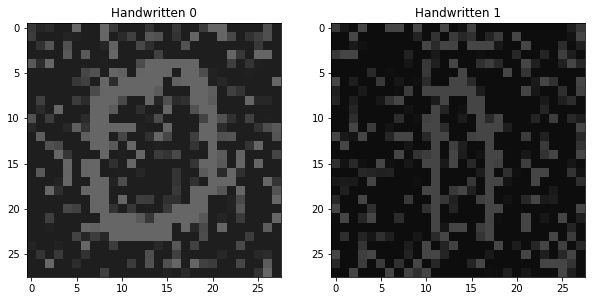

In [28]:
# your code here
# read in data
data_train = pd.read_csv('data/kmnist_train.csv')
data_test = pd.read_csv('data/kmnist_test.csv')

first_0 = data_train.output.eq(0).idxmax()
first_1 = data_train.output.eq(1).idxmax()

image_0 = data_train.drop('output',axis=1).iloc[first_0].values.reshape(28,28)
image_1 = data_train.drop('output',axis=1).iloc[first_1].values.reshape(28,28)

fig, ax = plt.subplots(1,2, figsize = (2*5,1*5))
ax[0].imshow(image_0, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].set_title('Handwritten 0')
ax[1].imshow(image_1, cmap = 'gray', vmin = 0, vmax = 255)
ax[1].set_title('Handwritten 1')

<a id="s22"></a>

<div class='exercise-r'>

**[2.2:](#q22) Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting.
    
</div>

In [29]:
# your code here
# standardize the train and test data
predictors = data_train.drop('output',axis=1).columns

scaler = StandardScaler().fit(data_train[predictors])

data_train[predictors] = scaler.transform(data_train[predictors])
data_test[predictors] = scaler.transform(data_test[predictors])

In [30]:
# your code here
# To build the NN, we will use the keras library
model_overfit = tf.keras.models.Sequential(name='model_overfit')

# We add the input layer
model_overfit.add(tf.keras.layers.Input(shape = (data_train.drop('output',axis=1).shape[1],)))

# We add the first hidden layer with 100 neurons 
# and 'relu' activation
model_overfit.add(tf.keras.layers.Dense(100, activation = 'relu', name='hidden1'))

# We add the second hidden layer with 100 neurons 
# and 'relu' activation
model_overfit.add(tf.keras.layers.Dense(100, activation = 'relu',name='hidden2'))

# We add the third hidden layer with 100 neurons 
# and 'relu' activation
model_overfit.add(tf.keras.layers.Dense(100, activation = 'relu',name='hidden3'))

# output layer, one neuron, using 'sigmoid' on the output labels
model_overfit.add(tf.keras.layers.Dense(1, activation = 'sigmoid',name='output'))
    
# Now we compile the model using 'binary_crossentropy' loss, 
# and optimizer as 'adam'
model_overfit.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_overfit.summary()

# We fit the model, set epochs=1000, batch_size=128, and validation_split=0.3
history = model_overfit.fit(data_train.drop('output',axis=1),data_train.output,
                    epochs = 1000, batch_size = 128, verbose = 0,validation_split = 0.3)

Model: "model_overfit"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


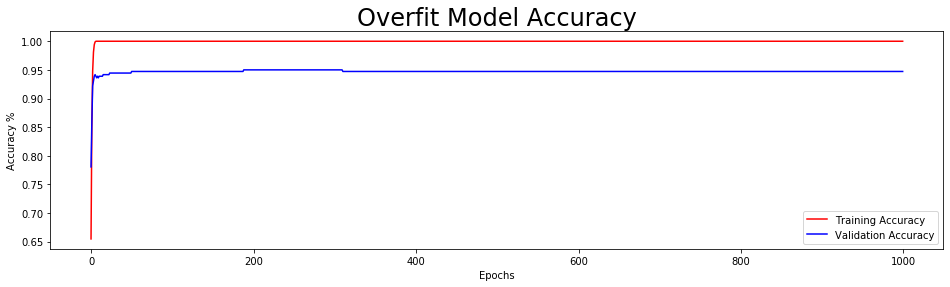

In [31]:
# plot train and val acc as a function of epochs
# your code here
# Here we plot the training and validation loss and accuracy

plt.figure(figsize=(16,4))
plt.plot(history.history['accuracy'],'r',label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs');
plt.ylabel('Accuracy %');
plt.title('Overfit Model Accuracy', fontsize = 24)
plt.show()

**INTERPRETATION:**

*Your answer here*

We can tell that this model is overfitting because, for almost all of the epochs that we're iterating over, the Training Accuracy remains constant at about 100\%, which implies that there is perfect fit on the training data as we expect for an overfit model. More importantly, we see that the Validation Accuracy is a flat line over almost all of the epochs, meaning that the model is doing no better over higher Epochs (more iterations) on the vaidation data. With each Epoch that is iterated, the model refines the weights in the network and optimizes to fit the training data perfectly, explaining the perfect training accuracy in the plot. Once the model predicts the training data perfectly, in each Epoch the weights are minimally adjusted or not adjusted at all, explaining why the Validation Accuracy also flat lines around the same Epoch that the Training Accuracy flatlines. Since the model optimizes perfectly for the training data, we know that it is overfitting because it is trading off it's ability to generalize to unknown data by fitting on the training data so perfectly.

<a id="s23"></a>

<div class='exercise-r'>

**[2.3:](#q23) Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs/RNNs/enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109A [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

<a id="s231"></a>

**[2.3.1:](#q23)** Build and train your regularized model (you MUST adhere to the "DOS" and "DON'TS" listed above), print your model summary, and print your final training and validation accuracy and loss.
    
</div>

In [133]:
# your code here
tf.keras.backend.clear_session()

model_reg = tf.keras.models.Sequential(name='model_regularized')

# We add the input layer
model_reg.add(tf.keras.layers.Input(shape = (data_train.drop('output',axis=1).shape[1],)))

# We add the first hidden layer with 100 neurons
# and 'relu' activation
model_reg.add(tf.keras.layers.Dense(100, activation='relu', name='hidden1',
                                    kernel_initializer='random_normal', bias_initializer='random_normal',
                                    kernel_regularizer=tf.keras.regularizers.l1(l=0.01),
                                    bias_regularizer=tf.keras.regularizers.l1(l=0.01)))

# We add the second hidden layer with 100 neurons
# and 'relu' activation
model_reg.add(tf.keras.layers.Dense(100, activation='relu',name='hidden2'))

# Add dropout layer for regularization
model_reg.add(tf.keras.layers.Dropout(0.25))

# We add the third hidden layer with 100 neurons
# and 'relu' activation
model_reg.add(tf.keras.layers.Dense(100, activation='relu',name='hidden3'))

# output layer, one neuron, using 'sigmoid' on the output labels
model_reg.add(tf.keras.layers.Dense(1, activation = 'sigmoid',name='output'))

# callbacks: watch validation loss and be "patient" for 20 epochs of no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=100, restore_best_weights=True)

# Now we compile the model using 'binary_crossentropy' loss, 
# and optimizer as 'adam'
model_reg.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model_reg.summary()

# We fit the model, set epochs=2000, batch_size=16, and validation_split=0.3
history_reg = model_reg.fit(data_train.drop('output',axis=1),data_train.output, epochs = 2000,
                            batch_size = 16, verbose = 0,validation_split = 0.3, callbacks=[es])

Model: "model_regularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


In [134]:
# your code here
# because we use restore_best_weights in our early stopping, we need to find the index of our minimum
# validation loss to find the other metrics
index = np.argmin(history_reg.history['val_loss'])
print('Final Training Accuracy: ' + str(round(history_reg.history['accuracy'][index],4)))
print('Final Validation Accuracy: ' + str(round(history_reg.history['val_accuracy'][index],4)))
print('Final Training Loss: ' + str(round(history_reg.history['loss'][index],4)))
print('Final Validation Loss: ' + str(round(history_reg.history['val_loss'][index],4)))

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.95
Final Training Loss: 0.1796
Final Validation Loss: 0.4023


<a id="s232"></a>

<div class='exercise-r'>

**[2.3.2:](#q23)** Plot your model's training accuracy and validation accuracy as a function of epochs.

</div>

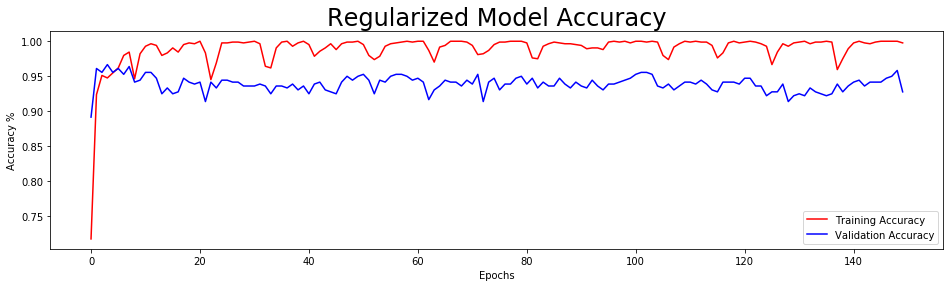

In [135]:
# plot train and val acc as a function of epochs
# your code here
# Here we plot the training and validation loss and accuracy

plt.figure(figsize=(16,4))
plt.plot(history_reg.history['accuracy'],'r',label = 'Training Accuracy')
plt.plot(history_reg.history['val_accuracy'],'b',label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs');
plt.ylabel('Accuracy %');
plt.title('Regularized Model Accuracy', fontsize = 24)
plt.show()

<a id="s233"></a>

<div class='exercise-r'>

**[2.3.3:](#q23)** In several sentences, describe the approach you have taken to improve the performance of your regularized model in 2.3.1 and any observations you might have regarding your training and Kaggle results.

</div>

**APPROACH AND OBSERVATIONS:**

*Your answer here*

I utilize three methods of regularization to improve the performance of the model from 2.3.1. I first use early-stopping, utilizing the method that Pavlos mentioned his lecture is his preferred manner of early-stopping. I allow my model to run for up to 2000 Epochs and set a high patience of 100 Epochs, but I set my early-stopping to revert the weights to the Epoch where the Validation Loss was the lowest, so I allow my model to have a high patience so that it can iterate over many Epochs and select the best Epoch with the most generalizable results that it iterated through. I discovered through many different trials that the best batch_size for the model is 16. I chose to handle each hidden layer differently based on the complexity of the images it worked with. I decided to use L1 Regularization on the weights and bias of the first layer, since the first layer works with just the edges of the images, so I felt that regularizing with sparsity was most effective for this layer. Moreover, there was considerable noise in the visualized images from 2.1, so I felt it was important to regularize bias in our first hidden layer. For the second hidden layer, since it works with the contours of the shapes in the images, I decided to use Dropout because the 0 and 1 have extremely similar contours and I did not want the weights to overexaggerate particular handwriting features (such as messy or narrow writing) that is present in the training data set. For the final hidden layer, I decided not to regularize that layer because it works with specific features of the objects and I felt that the most important feature for the NN model to pick up was that the 1 was identical to a 0 except that the bottom section is missing. The final hidden layer is best suited to pick up this distinction so I decided not to regularize that layer. The model seemed to perform well, scoring a 0.941 on the Test set on Kaggle and scoring slightly better on the Validation data with an accuracy of 0.95. Of course, because we are regularizing an over fit model, the model also perfectly predicts on the training data set.

<a id="s234"></a>

<div class='exercise-r'>

**[2.3.4:](#q23)** Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109A Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions, the second must be named `"category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location.

</div>

In [136]:
# your code here
preds = (model_reg.predict(data_test)>0.5).astype(int)
submission = pd.DataFrame(preds, columns = ['category']).reset_index().rename(columns = {'index': 'id'})
submission.to_csv('data/submission.csv', index=False)

<a id="s235"></a>

<div class='exercise-r'>

**[2.3.5:](#q23)** **Specify your Kaggle name that you have used on the leaderboard**. We CAN NOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

*Your answer here*

Test Test Test

[Return to contents](#contents)